# Brain Tumor Detection

A brain tumor is a mass or growth of abnormal cells in the brain. Brain tumors can be cancerous (malignant) or noncancerous (benign).

One of the tests to diagnose brain tumor is magnetic resonance imaging (MRI).

A brain MRI images dataset founded on Kaggle.

The dataset contains 2 folders: yes and no which contains 253 Brain MRI Images. The folder yes contains 155 Brain MRI Images that are tumorous (malignant) and the folder no contains 98 Brain MRI Images that are non-tumorous (benign).

In order to be fed into the Neural Network we have to pre-process the dataset images by performing Data Augmentation, Cropping the part of the image which has the brain in it and resizing all the images to have an uniform size.

In [1]:
from keras.preprocessing.image import ImageDataGenerator,img_to_array
import cv2
import time
from os import listdir

import warnings
warnings.filterwarnings('ignore')

Using TensorFlow backend.


### Data Preprocessing

The point of interest for us in all the images is the brain itself, so we will use the crop the image by using the technique of finding extreme points using OpenCV .
[Finding Extreme Points with OpenCV](https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/)


In [2]:
import imutils
import cv2
import matplotlib.pyplot as plt

def crop_brain_contours(image, plot_image = False):
    # convert image to grayscale, and blur it slightly
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    gray = cv2.GaussianBlur(gray, (5, 5), 0)

    # threshold the image, then perform a series of erosions +
    # dilations to remove any small regions of noise
    thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
    thresh = cv2.erode(thresh, None, iterations=2)
    thresh = cv2.dilate(thresh, None, iterations=2)

    # find contours in thresholded image, then grab the largest
    # one
    cnts = cv2.findContours(thresh.copy(),
                            cv2.RETR_EXTERNAL, 
                            cv2.CHAIN_APPROX_SIMPLE)
    cnts = imutils.grab_contours(cnts)
    c = max(cnts, key=cv2.contourArea)
    # determine the most extreme points along the contour
    extLeft = tuple(c[c[:, :, 0].argmin()][0])
    extRight = tuple(c[c[:, :, 0].argmax()][0])
    extTop = tuple(c[c[:, :, 1].argmin()][0])
    extBot = tuple(c[c[:, :, 1].argmax()][0])
    # crop new image out of the original image using the four extreme points (left, right, top, bottom)
    new_image = image[extTop[1]:extBot[1], extLeft[0]:extRight[0]] 
    
    if plot_image:
        plt.figure()
        plt.subplot(1 , 2 ,1)
        plt.imshow(image)
#         plt.tick_params(axis='both', which='both', 
#                         top=False, bottom=False, left=False, right=False,
#                         labelbottom=False, labeltop=False, labelleft=False, labelright=False)
        plt.title('Original Image')
        plt.subplot(1 , 2 ,2)
        plt.imshow(new_image)
#         plt.tick_params(axis='both', which='both', 
#                         top=False, bottom=False, left=False, right=False,
#                         labelbottom=False, labeltop=False, labelleft=False, labelright=False)
       
        plt.title('Cropped Image')
        
        plt.show()
    return new_image

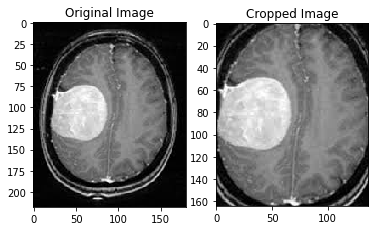

In [3]:
# test cropping 
test_image = cv2.imread(r'Dataset\yes\Y1.jpg')
test_image = crop_brain_contours( test_image ,True )

### Load the augmented images data

The following function takes two arguments, the first one is a list of directory paths for the folders 'yes' and 'no' that contain the image data and the second argument is the image size, and for every image in both directories and does the following:

    1) Read the image.
    2) Crop the part of the image representing only the
    brain.
    3) Resize the image (because the images in the dataset
    come in different sizes (meaning width, height and # of
    channels). So, we want all of our images to be (240, 240,
    3) to feed it as an input to the neural network.
    4) Apply normalization because we want pixel values to be
    scaled to the range 0-1.
    5) Append the image to X and its label to y.

After that, Shuffle X and y, because the data is ordered (meaning the arrays contains the first part belonging to one class and the second part belonging to the other class, and we don't want that).
Finally, Return X and y.

In [4]:
import numpy as np
from sklearn.utils import shuffle

def prepare_images(directory_list , image_size):
    """
    directory_list : List of file directories
    image_size : Target size of the image, Height X Width
        
    """
    image_width ,image_height = image_size 
    X = []
    y =[]
    # Load all images in the directory
 
    for directory in directory_list:
        for file in listdir(directory):
            read_path = directory + '\\' + file
            image = cv2.imread(read_path)
            image = crop_brain_contours(image ,False)
            image = cv2.resize(image ,dsize = (image_width ,image_height),
                               interpolation = cv2.INTER_CUBIC)
            # normalize values
            image = image / 255.
            
            X.append(image)
            # Create appropriate labels according to the folder
            if directory[-3:] == 'yes':
                y.append([1])
            else:
                y.append([0])
    
    X = np.array(X)
    y = np.array(y)
    
    X, y = shuffle(X,y)
    return X,y
            
             

In [8]:
augmented_yes_path = r'Dataset\augmented_data\yes'
augmented_no_path = r'Dataset\augmented_data\no'

X , y = prepare_images([augmented_yes_path ,augmented_no_path],
                       (240,240))

print('Total number of example : {}'.format(len(X)))
print('Shape of X :{}'.format(X.shape) )
print('Shape of y :{}'.format(y.shape) )


Total number of example : 2065
Shape of X :(2065, 240, 240, 3)
Shape of y :(2065, 1)


### Plot processed images

In [9]:
def plot_sample_images(X, y , n=50):
    for label in [0,1]:
        images = X[np.argwhere(y==label)]
        images = images[:n]
        
        columns_needed = 10
        rows_needed = int( n / 10 )
        
        plt.figure(figsize=(20,10))
        
        i = 1
        for image in images:
            plt.subplot(rows_needed , columns_needed ,i)
            plt.imshow(image[0])
            i += 1
         
        label_string = lambda label : 'Yes' if label == 1 else 'No'
        plt.suptitle(f'Brain Tumor: {label_string(label)}')
        plt.show()
            

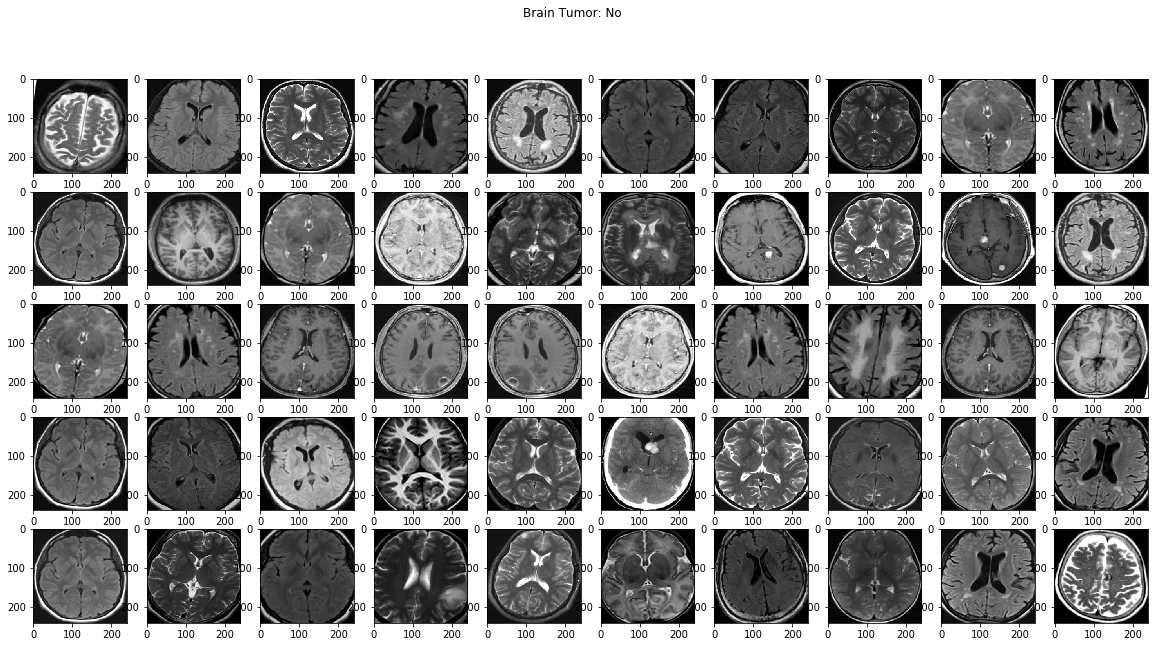

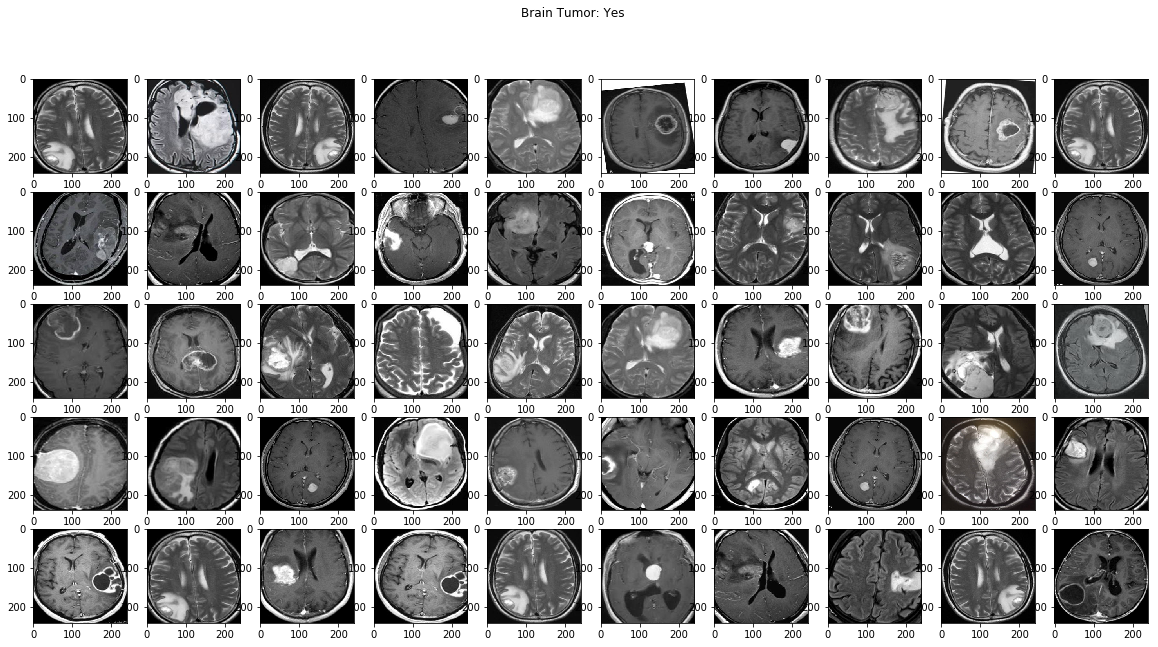

In [10]:
plot_sample_images(X,y)

### Split Data

In [11]:
from sklearn.model_selection import train_test_split
def split_data(X , y ,test_size):
    """
    Splits data into training, development and test sets.
    Arguments:
        X: A numpy array with shape = (#_examples, image_width, image_height, #_channels)
        y: A numpy array with shape = (#_examples, 1)
    Returns:
        X_train: A numpy array with shape = (#_train_examples, image_width, image_height, #_channels)
        y_train: A numpy array with shape = (#_train_examples, 1)
        X_val: A numpy array with shape = (#_val_examples, image_width, image_height, #_channels)
        y_val: A numpy array with shape = (#_val_examples, 1)
        X_test: A numpy array with shape = (#_test_examples, image_width, image_height, #_channels)
        y_test: A numpy array with shape = (#_test_examples, 1)
    """ 
    
    X_train ,X_test_val ,y_train ,y_test_val = train_test_split(X , y ,test_size= test_size)
    X_test, X_val ,y_test ,y_val = train_test_split(X_test_val ,y_test_val , test_size = 0.5)
    
    return X_train ,y_train ,X_val ,y_val ,X_test ,y_test

In [12]:
X_train ,y_train ,X_val ,y_val ,X_test ,y_test = split_data(X , y ,test_size= 0.3)

In [13]:
print('X_train shape : {}'.format(X_train.shape))
print('X_test shape : {}'.format(X_test.shape))
print('X_val shape : {}'.format(X_val.shape))
print('y_train shape : {}'.format(y_train.shape))
print('y_val shape : {}'.format(y_val.shape))
print('y_test shape : {}'.format(y_test.shape))


X_train shape : (1445, 240, 240, 3)
X_test shape : (310, 240, 240, 3)
X_val shape : (310, 240, 240, 3)
y_train shape : (1445, 1)
y_val shape : (310, 1)
y_test shape : (310, 1)


### Build the model

We will build a convolutional neural network in order to predict if brain scan image has brain tumor or not by training our model on the preprocessed images

In [19]:
from keras.models import Sequential
from keras.layers.core import Dense, Activation ,Dropout

from keras.layers import Conv2D,Input,ZeroPadding2D,BatchNormalization ,MaxPooling2D ,Flatten
from keras.models import Model ,load_model
from sklearn.metrics import f1_score

In [27]:
def build_model( input_shape ):
    
    model = Sequential()
    
#     X_input = Input(input_shape)
    
    model.add(ZeroPadding2D(2, input_shape = input_shape))
    model.add(Conv2D(32 ,(7,7) ))
    model.add(BatchNormalization(axis = 3))
    model.add(Activation('relu'))
    
    model.add(MaxPooling2D(pool_size = (4,4)) )
    model.add(Dropout(0.25))
    model.add(MaxPooling2D(pool_size = (4,4)) )
           
    model.add(Flatten())
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    # Let's train the model using RMSprop
    model.compile(loss='binary_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy']) 
    
    return model

In [28]:
image_shape = 240 ,240 ,3
model = build_model( image_shape )
model.summary()

W0911 22:38:28.816972  1880 deprecation_wrapper.py:119] From C:\Users\i323570\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:1834: The name tf.nn.fused_batch_norm is deprecated. Please use tf.compat.v1.nn.fused_batch_norm instead.

W0911 22:38:29.032237  1880 deprecation_wrapper.py:119] From C:\Users\i323570\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3976: The name tf.nn.max_pool is deprecated. Please use tf.nn.max_pool2d instead.

W0911 22:38:29.049100  1880 deprecation.py:506] From C:\Users\i323570\AppData\Local\Continuum\anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W0911 22:38:29.131932  1880 deprecation_wrapper.py:119] From C:\Users\i323570

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
zero_padding2d_2 (ZeroPaddin (None, 244, 244, 3)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 238, 238, 32)      4736      
_________________________________________________________________
batch_normalization_1 (Batch (None, 238, 238, 32)      128       
_________________________________________________________________
activation_1 (Activation)    (None, 238, 238, 32)      0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 59, 59, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 59, 59, 32)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 14, 14, 32)        0         
__________

In [29]:
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint

# tensorboard
log_file_name = f'brain_tumor_detection_cnn_{int(time.time())}'
tensorboard = TensorBoard(log_dir=f'logs/{log_file_name}')

In [33]:
# checkpoint
# unique file name that will include the epoch and the validation (development) accuracy
filepath=r"cnn-parameters-improvement-{epoch:02d}-{val_acc:.2f}"
# save the model with the best validation (development) accuracy till now
checkpoint = ModelCheckpoint("models/{}.model".format(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='max'))

In [35]:
start_time = time.time()
start_time = time.time()

# model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val) )

end_time = time.time()
execution_time = (end_time - start_time)

print('Elapsed time for training:{}'.format(execution_time))

Train on 1445 samples, validate on 310 samples
Epoch 1/10
1445/1445 [==============================] - 115s 79ms/step - loss: 0.8892 - acc: 0.6304 - val_loss: 0.6854 - val_acc: 0.6645
Epoch 2/10
1445/1445 [==============================] - 86s 59ms/step - loss: 0.5496 - acc: 0.7412 - val_loss: 0.4621 - val_acc: 0.7903
Epoch 3/10
1445/1445 [==============================] - 87s 60ms/step - loss: 0.3725 - acc: 0.8422 - val_loss: 0.4958 - val_acc: 0.7452
Epoch 4/10
1445/1445 [==============================] - 81s 56ms/step - loss: 0.3417 - acc: 0.8664 - val_loss: 0.5194 - val_acc: 0.7226
Epoch 5/10
1445/1445 [==============================] - 84s 58ms/step - loss: 0.3047 - acc: 0.8782 - val_loss: 0.3656 - val_acc: 0.8484
Epoch 6/10
1445/1445 [==============================] - 79s 55ms/step - loss: 0.2833 - acc: 0.8830 - val_loss: 0.3610 - val_acc: 0.8581
Epoch 7/10
1445/1445 [==============================] - 81s 56ms/step - loss: 0.2436 - acc: 0.9066 - val_loss: 0.3568 - val_acc: 0.8613


In [37]:
# Lets train for 10 more epochs
start_time = time.time()

# model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val), callbacks=[tensorboard, checkpoint])
model.fit(x=X_train, y=y_train, batch_size=32, epochs=10, validation_data=(X_val, y_val) )

end_time = time.time()
execution_time = (end_time - start_time)

print('Elapsed time for training:{:,.2f}'.format(execution_time))

Train on 1445 samples, validate on 310 samples
Epoch 1/10
1445/1445 [==============================] - 89s 62ms/step - loss: 0.0879 - acc: 0.9709 - val_loss: 0.3124 - val_acc: 0.8677
Epoch 2/10
1445/1445 [==============================] - 88s 61ms/step - loss: 0.0701 - acc: 0.9758 - val_loss: 0.2567 - val_acc: 0.9032
Epoch 3/10
1445/1445 [==============================] - 76s 53ms/step - loss: 0.0538 - acc: 0.9855 - val_loss: 0.2703 - val_acc: 0.8968
Epoch 4/10
1445/1445 [==============================] - 79s 55ms/step - loss: 0.0523 - acc: 0.9875 - val_loss: 0.2649 - val_acc: 0.9000
Epoch 5/10
1445/1445 [==============================] - 82s 57ms/step - loss: 0.0532 - acc: 0.9896 - val_loss: 0.5534 - val_acc: 0.8097
Epoch 6/10
1445/1445 [==============================] - 88s 61ms/step - loss: 0.0685 - acc: 0.9765 - val_loss: 0.3065 - val_acc: 0.8613
Epoch 7/10
1445/1445 [==============================] - 77s 54ms/step - loss: 0.0495 - acc: 0.9869 - val_loss: 0.3785 - val_acc: 0.8774
E

In [38]:
history = model.history.history
for key in history.keys():
    print(key)

val_loss
val_acc
loss
acc


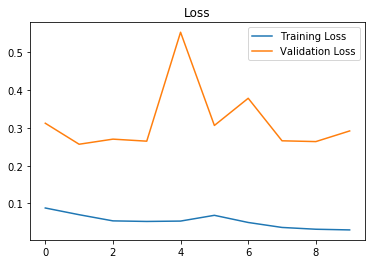

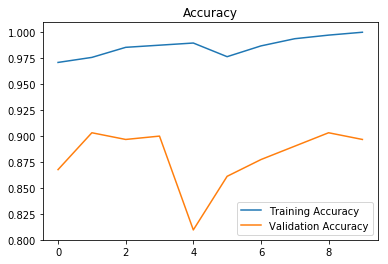

In [41]:
import matplotlib.pyplot as plt

# Loss
plt.figure()
plt.plot(history['loss'], label='Training Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.title('Loss')
plt.legend()
plt.show()

# Accuracy
plt.figure()
plt.plot(history['acc'], label='Training Accuracy')
plt.plot(history['val_acc'], label='Validation Accuracy')
plt.title('Accuracy')
plt.legend()
plt.show()

In [42]:
y_test_pred = model.predict(X_test)


In [46]:
score = model.evaluate(X_test ,y_test)

310/310 [==============================] - 7s 23ms/step


In [48]:
score[1]

0.9129032277291821